In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.neighbors import KNeighborsClassifier

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14

In [2]:
file = "arxiv-metadata-oai-snapshot.json"
def get_data():
    with open(file) as f:
        for line in f:
            yield line

In [3]:
dataframe = {
    'title': [],
    'year': [],
    'abstract': []
}

data = get_data()
for i, paper in enumerate(data):
    paper = json.loads(paper)
    try:
        date = int(paper['update_date'].split('-')[0])
        if date > 2019:
            dataframe['title'].append(paper['title'])
            dataframe['year'].append(date)
            dataframe['abstract'].append(paper['abstract'])
    except: pass

In [4]:
df = pd.DataFrame(dataframe)
df.head(10)

,title,year,abstract
0,Convergence of the discrete dipole approximati...,2022,We performed a rigorous theoretical converge...
1,The discrete dipole approximation: an overview...,2022,We present a review of the discrete dipole a...
2,Mapping radii of metric spaces,2021,It is known that every closed curve of lengt...
3,What can emission lines tell us?,2023,1 Generalities\n 2 Empirical diagnostics ba...
4,The affine part of the Picard scheme,2021,We describe the maximal torus and maximal un...
5,Manifolds admitting a $\tilde G_2$-structure,2023,We find a necessary and sufficient condition...
6,Actions for the Bosonic String with the Curved...,2020,At first we introduce an action for the stri...
7,Stochastic action principle and maximum entropy,2020,A stochastic action principle for stochastic...
8,Axiom A polynomial skew products of C^2 and th...,2023,A polynomial skew product of C^2 is a map of...
9,Depletion effects in smectic phases of hard ro...,2022,It is known that when hard spheres are added...


In [5]:
del dataframe
print(f"Samples: {df.shape[0]}\nFeatures: {df.shape[1]}")

Samples: 817256
Features: 3


In [6]:
any(df.isna().sum())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817256 entries, 0 to 817255
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     817256 non-null  object
 1   year      817256 non-null  int64 
 2   abstract  817256 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.7+ MB


In [7]:
df['length'] = df['abstract'].str.len()
df.head(10)

,title,year,abstract,length
0,Convergence of the discrete dipole approximati...,2022,We performed a rigorous theoretical converge...,832
1,The discrete dipole approximation: an overview...,2022,We present a review of the discrete dipole a...,617
2,Mapping radii of metric spaces,2021,It is known that every closed curve of lengt...,737
3,What can emission lines tell us?,2023,1 Generalities\n 2 Empirical diagnostics ba...,181
4,The affine part of the Picard scheme,2021,We describe the maximal torus and maximal un...,126
5,Manifolds admitting a $\tilde G_2$-structure,2023,We find a necessary and sufficient condition...,220
6,Actions for the Bosonic String with the Curved...,2020,At first we introduce an action for the stri...,414
7,Stochastic action principle and maximum entropy,2020,A stochastic action principle for stochastic...,770
8,Axiom A polynomial skew products of C^2 and th...,2023,A polynomial skew product of C^2 is a map of...,784
9,Depletion effects in smectic phases of hard ro...,2022,It is known that when hard spheres are added...,1808


In [8]:
def word_count(x):
    return len(x.split())

df['word_count'] = df['abstract'].apply(word_count)
df.head()

,title,year,abstract,length,word_count
0,Convergence of the discrete dipole approximati...,2022,We performed a rigorous theoretical converge...,832,133
1,The discrete dipole approximation: an overview...,2022,We present a review of the discrete dipole a...,617,96
2,Mapping radii of metric spaces,2021,It is known that every closed curve of lengt...,737,138
3,What can emission lines tell us?,2023,1 Generalities\n 2 Empirical diagnostics ba...,181,27
4,The affine part of the Picard scheme,2021,We describe the maximal torus and maximal un...,126,21


In [9]:
print(f"Mean of Word Count: {df['word_count'].mean():.2f}\nMedian of Word Count: {df['word_count'].median()}")

Mean of Word Count: 156.50
Median of Word Count: 154.0


In [10]:
df['processed abstracts'] = pd.read_csv('processed abstracts.csv')

In [11]:
df

,title,year,abstract,length,word_count,processed abstracts
0,Convergence of the discrete dipole approximati...,2022,We performed a rigorous theoretical converge...,832,133,perform rigorous theoretical convergence analy...
1,The discrete dipole approximation: an overview...,2022,We present a review of the discrete dipole a...,617,96,present review discrete dipole approximation d...
2,Mapping radii of metric spaces,2021,It is known that every closed curve of lengt...,737,138,know closed curve length \leq 4 r^n n>0 surrou...
3,What can emission lines tell us?,2023,1 Generalities\n 2 Empirical diagnostics ba...,181,27,1 generality 2 empirical diagnostic base emiss...
4,The affine part of the Picard scheme,2021,We describe the maximal torus and maximal un...,126,21,describe maximal torus maximal unipotent subgr...
...,...,...,...,...,...,...
817251,The Hamiltonian structure of the dispersionles...,2020,The Hamiltonian structure of the two-dimensi...,436,65,hamiltonian structure two-dimensional dispersi...
817252,DNA Transcription Mechanism with a Moving Enzyme,2021,Previous numerical investigations of an one-...,510,69,previous numerical investigation one-dimension...
817253,Degenerate Frobenius manifolds and the bi-Hami...,2020,The bi-Hamiltonian structure of certain mult...,717,101,bi-hamiltonian structure certain multi-compone...
817254,Hypercomplex Integrable Systems,2020,In this paper we study hypercomplex manifold...,658,99,paper study hypercomplex manifold dimension us...


In [12]:
MODEL_URL = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
sentence_encoder_layer = hub.KerasLayer(MODEL_URL,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="use")
abstracts = df["processed abstracts"].to_list()

In [13]:
from tqdm import tqdm
from IPython.utils import io
with io.capture_output() as captured:
    %pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

import spacy
from spacy.lang.en.stop_words import STOP_WORDS #import commen list of stopword

print(spacy.__version__)


3.0.9


In [14]:
import en_core_sci_lg

In [15]:
import string

punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

['or',
 'somewhere',
 'again',
 'almost',
 'whether',
 'us',
 'were',
 "n't",
 'just',
 'already']

In [16]:
parser = en_core_sci_lg.load()
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers 
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens]) 
    return mytokens

In [ ]:
tqdm.pandas()
df["processed_abstract"] = df["abstract"].progress_apply(spacy_tokenizer)

In [17]:
# Setup for embeddings computation
embeddings = []
batch_size = 300
num_batches = len(abstracts) // batch_size

In [18]:
# Compute Embeddings in batches
for i in range(num_batches):
    batch_abstracts = abstracts[i*batch_size : (i+1)*batch_size]
    batch_embeddings = sentence_encoder_layer(batch_abstracts)
    embeddings.extend(batch_embeddings.numpy())

# Embeddings for remaining abstracts
remaining_abstracts = abstracts[num_batches*batch_size:]
if len(remaining_abstracts) > 0:
    remaining_embeddings = sentence_encoder_layer(remaining_abstracts)
    embeddings.extend(remaining_embeddings.numpy())
    
embeddings = np.array(embeddings)
y = df.index

In [19]:
nn = KNeighborsClassifier(n_neighbors=6)
nn.fit(embeddings,y)

KNeighborsClassifier(n_neighbors=6)

In [20]:
def calculate_user_embedding(user_title):
    user_abstract = sentence_encoder_layer([user_title])
    return user_abstract.numpy()


def find_similar_papers(user_embeddings, k=5):
    dist, indices = nn.kneighbors(X=user_embeddings, n_neighbors=k)
    similar_paper_embeddings = embeddings[indices[0]]
    similar_paper_titles = df['title'].iloc[indices[0]].tolist()
    print("Titles: ", similar_paper_titles)
    print("Distances: ", dist)
    return indices[0], similar_paper_embeddings, dist, similar_paper_titles

In [21]:
model_info = {"model": nn}
embeddings_info = {"embeddings": embeddings}

with open("model.pkl", 'wb') as file:
    dill.dump(model_info, file)

with open("embeddings.pkl", 'wb') as file:
    dill.dump(embeddings_info, file)
    
df.to_csv("data.csv", index=False)

Processed user abstract:  large language model llm demonstrate impressive capability natural language processing internal mechanism unclear lack transparency pose unwanted risk downstream application understanding explain model crucial elucidate behavior limitation social impact paper introduce taxonomy explainability technique provide structured overview method explain transformer-based language model categorize technique base training paradigm llm traditional fine-tuning-based paradigm prompting-based paradigm paradigm summarize goal dominant approach generate local explanation individual prediction global explanation overall model knowledge discuss metric evaluate generate explanation discuss explanation leverage debug model improve performance lastly examine key challenge emerge opportunity explanation technique era llm comparison conventional machine learning model
user_embeddings:  (1, 512)
Titles:  ['Explainability for Large Language Models: A Survey', 'Towards Interpretable Dee

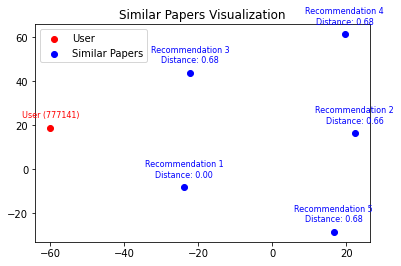

Cosine Similarities: [[1.0000001  0.78104824 0.77217036 0.77132905 0.7680114 ]]


In [22]:
user_title = "Explainability for Large Language Models: A Survey"
user_abstract = "Large language models (LLMs) have demonstrated impressive capabilities in natural language processing. However, their internal mechanisms are still unclear and this lack of transparency poses unwanted risks for downstream applications. Therefore, understanding and explaining these models is crucial for elucidating their behaviors, limitations, and social impacts. In this paper, we introduce a taxonomy of explainability techniques and provide a structured overview of methods for explaining Transformer-based language models. We categorize techniques based on the training paradigms of LLMs: traditional fine-tuning-based paradigm and prompting-based paradigm. For each paradigm, we summarize the goals and dominant approaches for generating local explanations of individual predictions and global explanations of overall model knowledge. We also discuss metrics for evaluating generated explanations, and discuss how explanations can be leveraged to debug models and improve performance. Lastly, we examine key challenges and emerging opportunities for explanation techniques in the era of LLMs in comparison to conventional machine learning models."
user_abstract_processed = spacy_tokenizer(user_abstract)
print("Processed user abstract: ", user_abstract_processed)
user_embeddings = calculate_user_embedding(user_abstract_processed)
print("user_embeddings: ", user_embeddings.shape)
similar_paper_indices, similar_paper_embeddings, distances, similar_paper_titles = find_similar_papers(user_embeddings)

# Assuming title embeddings start at index 0 and abstract embeddings start at index 512
title_embeddings = similar_paper_embeddings[:, :512]
abstract_embeddings = similar_paper_embeddings[:, 512:]

# Concatenate title and abstract embeddings
similar_paper_combined_embeddings = np.concatenate([title_embeddings, abstract_embeddings], axis=1)
print("similar_paper_combined_embeddings: ", similar_paper_combined_embeddings.shape)

for i, idx in enumerate(similar_paper_indices):
    recommended_paper = df['title'][idx]
    print(f"Recommendation {i + 1}:\n{recommended_paper}\n")


'''-------------------------- Scatter Plot ----------------------------'''

from sklearn.manifold import TSNE

def visualize_similar_papers(user_embeddings, similar_paper_embeddings, similar_paper_titles, distances):
    # Combine user embeddings and similar paper embeddings
    all_embeddings = np.concatenate([user_embeddings, similar_paper_embeddings])

    # Use t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # Separate user and paper embeddings
    user_embedding_2d = embeddings_2d[0].reshape(1, -1)
    paper_embeddings_2d = embeddings_2d[1:]

    # Visualize user and similar paper embeddings
    plt.scatter(user_embedding_2d[:, 0], user_embedding_2d[:, 1], color='red', label='User')

    # Annotate user point with the user index and distance
    plt.annotate(f"User ({similar_paper_indices[0]})", 
                 (user_embedding_2d[:, 0], user_embedding_2d[:, 1]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

    plt.scatter(paper_embeddings_2d[:, 0], paper_embeddings_2d[:, 1], color='blue', label='Similar Papers')

    # Annotate points with paper indices
    for i, (index, distance) in enumerate(zip(similar_paper_titles, distances[0])):
        plt.annotate(f"Recommendation {i+1}\nDistance: {distance:.2f}", 
                     (paper_embeddings_2d[i, 0], paper_embeddings_2d[i, 1]),
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')

    plt.title('Similar Papers Visualization')
    plt.legend()
    plt.show()

visualize_similar_papers(user_embeddings, similar_paper_embeddings, similar_paper_titles, distances)

'''-------------------- Cosine Similarity ---------------------'''

from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(user_embeddings, similar_paper_combined_embeddings)
print("Cosine Similarities:", similarities)

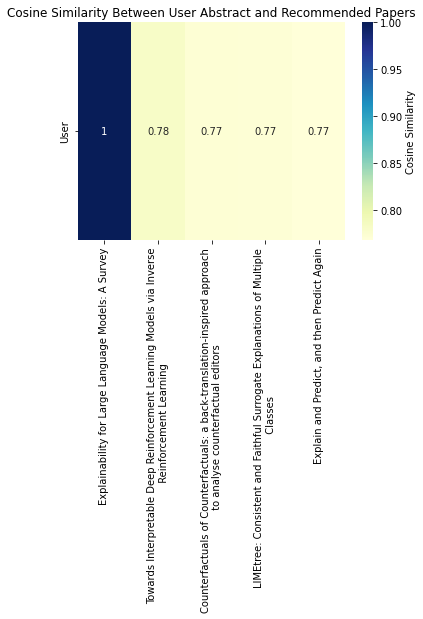

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming similarities is the array of cosine similarity scores
# (shape: (1, num_recommendations))

# Convert the similarities array to a 1D array
similarity_scores = similarities.flatten()

# Plot the heatmap
sns.heatmap([similarity_scores], annot=True, cmap="YlGnBu", xticklabels=similar_paper_titles,
            yticklabels=["User"], cbar_kws={'label': 'Cosine Similarity'})

plt.title('Cosine Similarity Between User Abstract and Recommended Papers')
plt.show()